## CAS Connection

In [1]:
import swat
s = swat.CAS(host, port)

## Import Helper Functions

In [2]:
import pandas as pd
import document_classification_scripts as scripts
demo = scripts.Demo(s)

NOTE: Added action set 'sampling'.
NOTE: Added action set 'pca'.
NOTE: Added action set 'fedsql'.
NOTE: Added action set 'deepLearn'.
NOTE: Added action set 'network'.
NOTE: Added action set 'transpose'.
NOTE: Added action set 'table'.
NOTE: Added action set 'builtins'.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'autotune'.
NOTE: Added action set 'session'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'aStore'.
NOTE: Added action set 'aggregation'.


# Example 1
## Cycle Enumeration on a Directed Graph
Cycles are closed pathways through a graph that traverse nodes in the graph no more than once.

In [3]:
nodes = {
    "node": ["A","B","C","D","E","F"],
} 
nodesDf = pd.DataFrame(nodes, columns = ["node"])
s.upload(nodesDf, casout={"name": "nodes", "replace": True});

links = {
    "from": ["A","A","B","C","C","D","D","E","E","F"],
    "to"  : ["B","E","C","A","D","E","F","B","C","E"]
} 
linksDf = pd.DataFrame(links, columns = ["from", "to"])
s.upload(linksDf, casout={"name": "links", "replace": True});

NOTE: Cloud Analytic Services made the uploaded file available as table NODES in caslib CASUSER(brrees).
NOTE: The table NODES has been created in caslib CASUSER(brrees) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table LINKS in caslib CASUSER(brrees).
NOTE: The table LINKS has been created in caslib CASUSER(brrees) from binary data uploaded to Cloud Analytic Services.


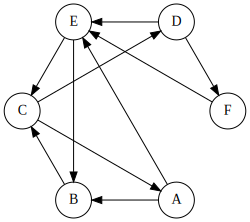

In [4]:
scripts.graph2dot(linksDf=s.CASTable("links"), nodesDf=s.CASTable("nodes"), layout='circo', directed=True, stdout=False)

In [5]:
s.loadactionset(actionset="network")
s.network.cycle(
    direction      = "directed",
    links          = {"name":"links"},
    nodes          = {"name":"nodes"},
    maxCycles      = "all",
    outCyclesNodes = {"name":"cycleNodes", "replace":True},
    outCyclesLinks = {"name":"cycleLinks", "replace":True});
demo.head("cycleLinks",7)

NOTE: Added action set 'network'.
NOTE: The number of nodes in the input graph is 6.
NOTE: The number of links in the input graph is 10.
NOTE: Processing cycle enumeration using 1 threads across 1 machines.
NOTE: The algorithm found 7 cycles.
NOTE: Processing cycle enumeration used 0.00 (cpu: 0.00) seconds.


,cycle,order,from,to
0,0,0,A,B
1,0,1,B,C
2,0,2,C,A
3,1,0,A,E
4,1,1,E,B
5,1,2,B,C
6,1,3,C,A


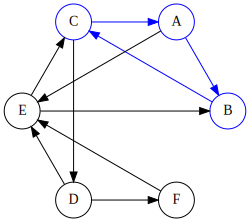

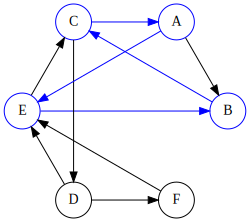

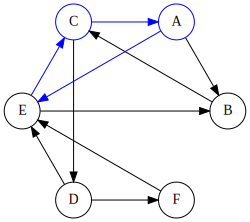

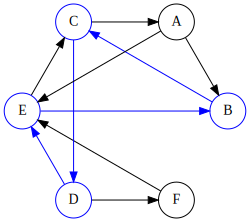

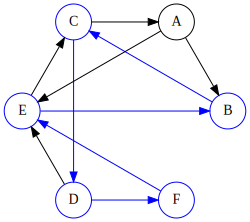

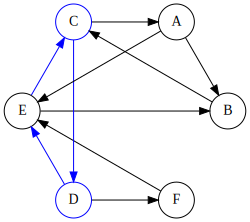

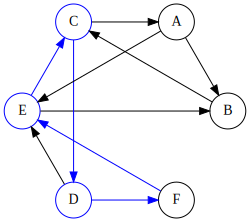

In [6]:
for i in range(7):
    display(demo.highlightCycle(i))

# Example 2

## Centrality of an Undirected Graph
Centrality algorithms give a quantitative measurement of how important, influential, or central a given node is to the graph, relative to the other nodes. 

In [7]:
links = {
    "from": ["B","D","D","E","E","E","F","G","G","H","H","I","I","J","K"],
    "to"  : ["C","A","B","B","D","F","B","B","E","B","E","B","E","E","E"]
} 
linksDf = pd.DataFrame(links, columns = ["from", "to"])
s.upload(linksDf, casout={"name": "links", "replace": True});

NOTE: Cloud Analytic Services made the uploaded file available as table LINKS in caslib CASUSER(brrees).
NOTE: The table LINKS has been created in caslib CASUSER(brrees) from binary data uploaded to Cloud Analytic Services.


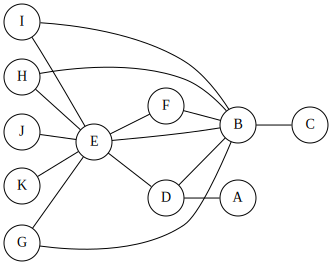

In [8]:
scripts.graph2dot(linksDf=s.CASTable("links"), stdout=False)

## Compute Closeness and Degree Centrality

In [9]:
s.network.centrality(
    links     = {"name":"links"},
    close     = "unweight",
    degree    = "unweight",
    outNodes  = {"name":"outCentralityNodes", "replace":True});
demo.head("outCentralityNodes")

NOTE: The number of nodes in the input graph is 11.
NOTE: The number of links in the input graph is 15.
NOTE: Processing centrality metrics.
NOTE: Processing centrality metrics used 0.00 (cpu: 0.00) seconds.


,node,centr_degree_out,centr_close_unwt
0,A,1,0.3846153846
1,B,7,0.7692307692
2,C,1,0.4545454545
3,D,3,0.5882352941
4,E,8,0.8333333333


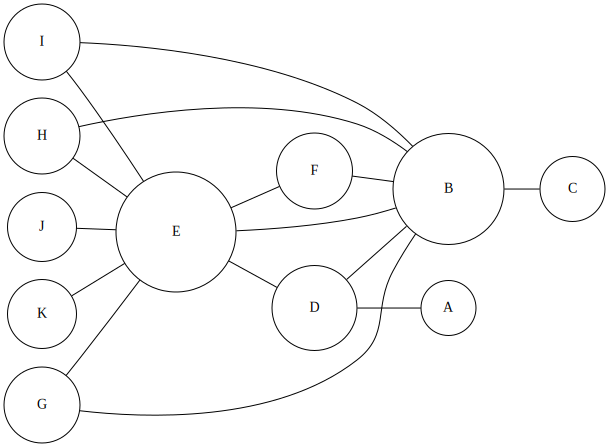

In [10]:
scripts.graph2dot(linksDf=s.CASTable("links"),
          nodesDf=s.CASTable("outCentralityNodes"),
          nodesSize="centr_close_unwt",
          nodesSizeScale=2,
          size=10,
          stdout=False
         )

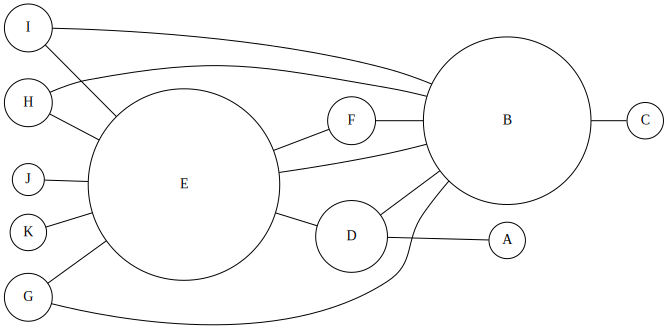

In [11]:
scripts.graph2dot(linksDf=s.CASTable("links"),
          nodesDf=s.CASTable("outCentralityNodes"),
          nodesSize="centr_degree_out",
          nodesSizeScale=1/3.0,
          size=10,
          stdout=False
         )

# Example 3
## Load Graph
What if you wanted to run multiple algorithms against the same graph? It is not ideal to load graph data from CAS tables every time, but this is, in fact, what happens when you specify the graph using the LINKS= and/or NODES= options.

A more efficient approach is available via the loadGraph and unloadGraph actions. When using loadGraph, the CAS tables are ingested only once, and in subsequent algorithm calls, you can point to an in-memory graph using the GRAPH= option in lieu of the LINKS= and NODES= options.

In [12]:
r = s.network.loadGraph(
    links = {"name":"links"},
    )
loadedGraph = r.graph

NOTE: The number of nodes in the input graph is 11.
NOTE: The number of links in the input graph is 15.


Next, compute pageRank and degree centrality on the loaded graph.

In [13]:
s.network.centrality(
    graph     = loadedGraph,
    pageRank  = "unweight",
    degree    = "unweight",
    outNodes  = {"name":"outCentralityNodes", "replace":True});

NOTE: The number of nodes in the input graph is 11.
NOTE: The number of links in the input graph is 15.
NOTE: Processing centrality metrics.
NOTE: Processing centrality metrics used 0.00 (cpu: 0.00) seconds.


Now, compute the shortest path from "K" to "C" in the loaded graph.

In [14]:
s.network.shortestPath(
    graph          = loadedGraph,
    source         = "K",
    sink           = "C",
    outPaths       = {"name":"pathLinks", "replace":True});

NOTE: The number of nodes in the input graph is 11.
NOTE: The number of links in the input graph is 15.
NOTE: Processing shortest paths problem using 32 threads across 1 machines.
NOTE: Processing the shortest paths problem between 1 source nodes and 1 sink nodes.
NOTE: Processing the shortest paths problem used 0.00 (cpu: 0.00) seconds.


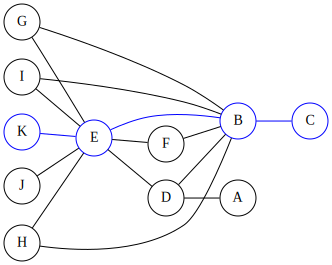

In [15]:
demo.highlightPath()

# Cleanup 
After the in-memory graph is no longer needed, you can free the graph with the unloadGraph action.

In [16]:
s.network.unloadGraph(
    graph = loadedGraph
);

In [17]:
s.terminate();